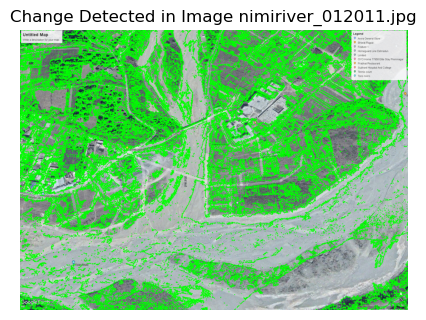

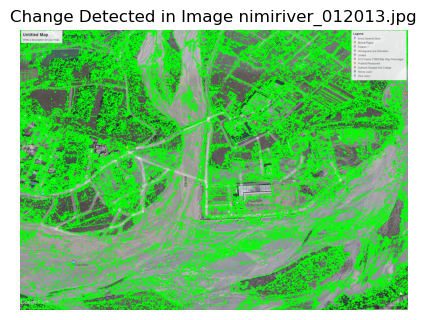

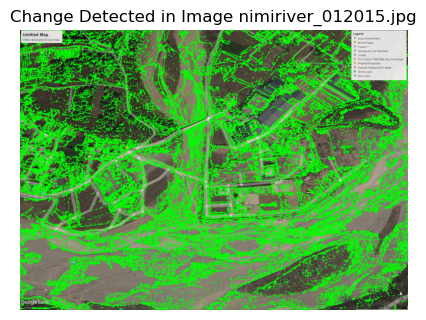

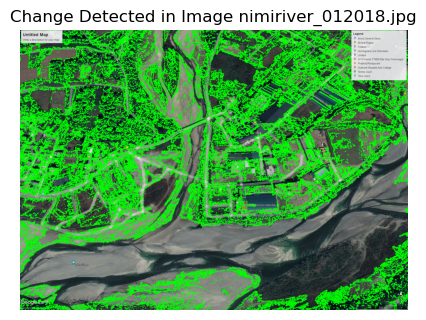

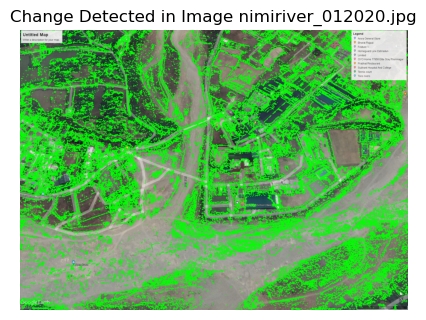

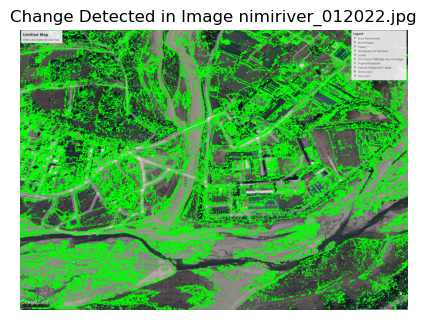

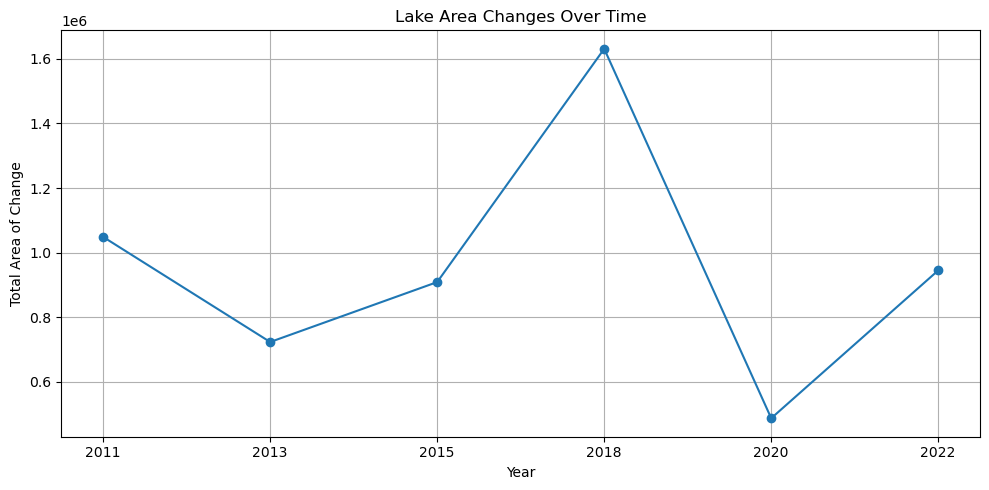

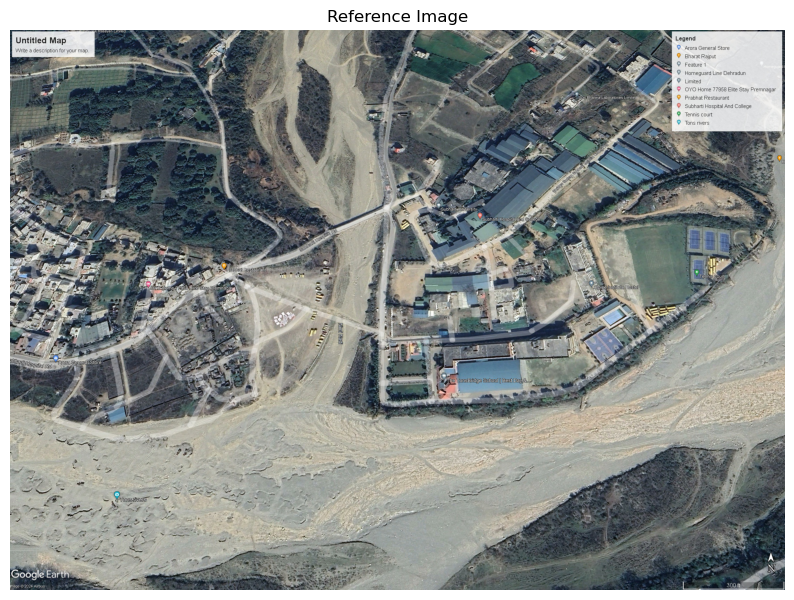

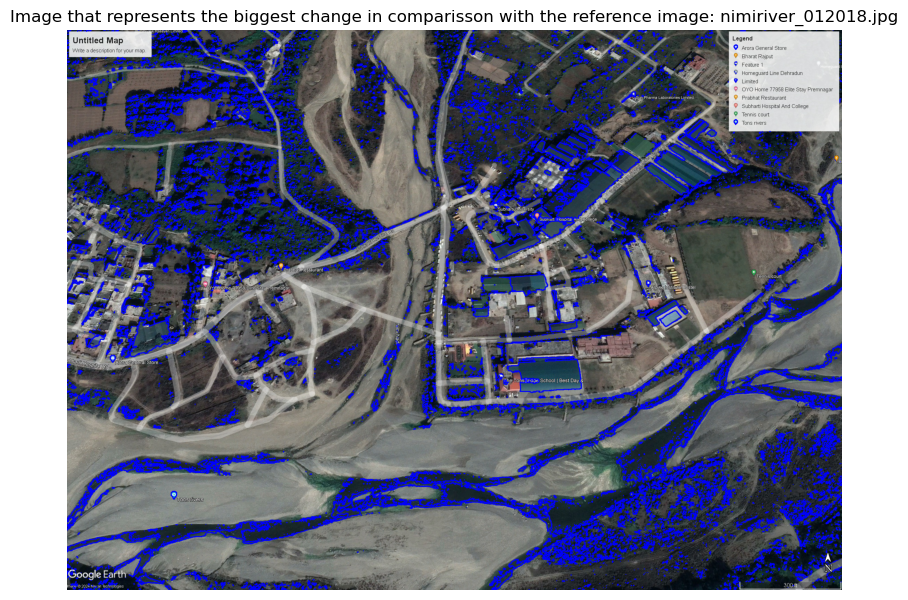

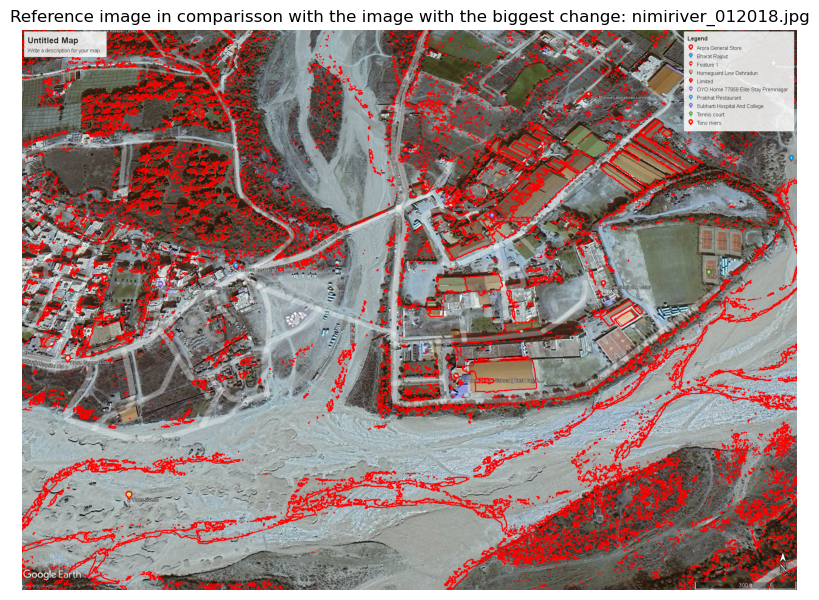


Summary of Detected Changes:
Image nimiriver_012011.jpg: 18640 regions changed with a total area of 1048397.50 pixels
Image nimiriver_012013.jpg: 31616 regions changed with a total area of 722922.00 pixels
Image nimiriver_012015.jpg: 22741 regions changed with a total area of 908571.50 pixels
Image nimiriver_012018.jpg: 19473 regions changed with a total area of 1631218.50 pixels
Image nimiriver_012020.jpg: 25388 regions changed with a total area of 486726.00 pixels
Image nimiriver_012022.jpg: 23983 regions changed with a total area of 944806.00 pixels


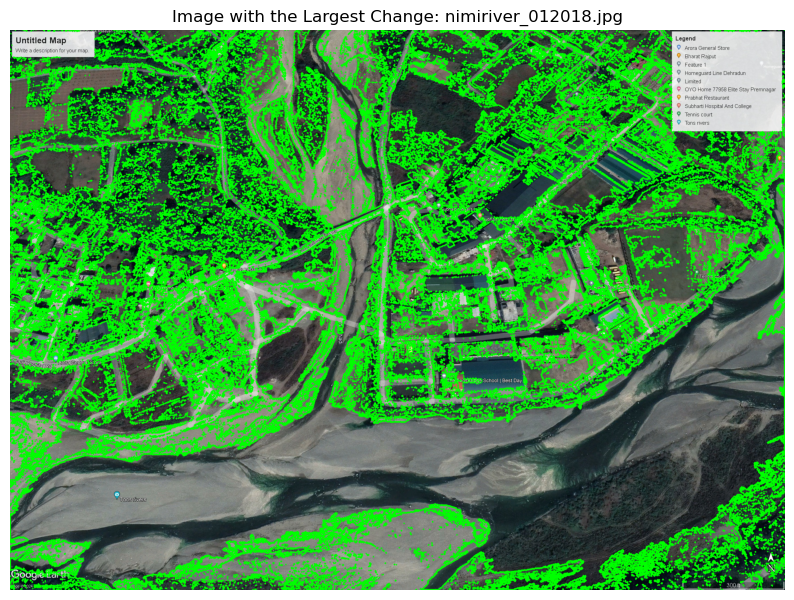

Total changed area across all images: 5742641.50 pixels
Total regions of change detected: 141841


In [1]:


import cv2
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import re

##Load the images - Read all the lake images into an array for processing.
##Preprocess the images - Convert the images to a comparable format, likely grayscale or thresholded binary images to highlight the lake.
##Compute differences - For each image, compute the difference with the reference image to identify changes.
##Analyze changes - Use the differences to quantify the changes in the lake area, color, or other relevant features.

##OpenCV, many operations require that the input images are of the same size and the same number of channels.
##Determine a common size: This could be the size of the smallest image, or a specific size you choose for your analysis.
##Resize all images to the common size: This will make sure all images have the same dimensions before any arithmetic operations are performed on them.

def load_images(image_files, base_directory):
    images = []
    reference_size = None
    for file in image_files:
        path = os.path.join(base_directory, file)
        image = cv2.imread(path, cv2.IMREAD_COLOR)
        if image is not None:
            if reference_size is None:
                reference_size = image.shape[1], image.shape[0]
            resized_image = cv2.resize(image, reference_size, interpolation=cv2.INTER_AREA)
            images.append(resized_image)
        else:
            print(f"Failed to load image: {file}")
    return images, reference_size
def preprocess_images(images):
    processed_images = []
    for image in images:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        processed_images.append(gray_image)
    return processed_images

def compute_differences(images):
    reference_image = images[0]
    differences = []
    for image in images[1:]:
        difference = cv2.absdiff(reference_image, image)
        differences.append(difference)
    return differences

def analyze_changes(differences):
    change_analysis = []
    change_stats = []
    for diff in differences:
        ret, thresh = cv2.threshold(diff, 50, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        total_area = sum(cv2.contourArea(contour) for contour in contours)
        change_analysis.append(contours)
        change_stats.append({'count': len(contours), 'area': total_area})
    return change_analysis, change_stats

# Define your image files and base directory
image_files = [
        "nimiriver_012023.jpg",
    "nimiriver_012011.jpg",
    "nimiriver_012013.jpg",
    "nimiriver_012015.jpg",
    "nimiriver_012018.jpg",
    "nimiriver_012020.jpg",
    "nimiriver_012022.jpg",

]
base_directory = "/Users/breisdas/Mastermind/NimiRiver/"
reference_image_path = os.path.join(base_directory, image_files[0])
reference_image = cv2.imread(reference_image_path)

def extract_date(filepath):
    filename = os.path.basename(filepath)
    match = re.search(r'nimiriver_(\d{2})(\d{4})\.jpg', filename)
    if match:
        date_str = match.group(1) + match.group(2)
        return datetime.strptime(date_str, '%m%Y')
    else:
        raise ValueError(f"Filename {filename} does not contain a valid date in MMYYYY format.")
        
def find_waterbody_contours(image):
    # Convert image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Define range for blue colors typically representing water
    lower_blue = np.array([90, 50, 50])
    upper_blue = np.array([150, 255, 255])
    # Create a binary mask where blue colors are white and the rest are black
    mask = cv2.inRange(hsv, lower_blue, upper_blue)
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def draw_waterbody_contours(image, contours):
    # Draw contours on the image
    cv2.drawContours(image, contours, -1, (255, 0, 0), 2)
    return image


# Load and preprocess the images
images, reference_size = load_images(image_files, base_directory)
if not images:
    print("No images could be loaded, exiting the analysis.")
else:
    processed_images = preprocess_images(images)
    differences = compute_differences(processed_images)
    changes, stats = analyze_changes(differences)

    # Find the image with the biggest change
    max_change_idx = max(range(len(stats)), key=lambda i: stats[i]['area'])
    biggest_change_image = image_files[max_change_idx + 1]

    # Display all images with changes
    for idx, change in enumerate(changes):
        plt.figure(figsize=(5,5))
        if change:
            for contour in change:
                # Green contours represent the detected changes
                cv2.drawContours(images[idx+1], contour, -1, (0,255,0), 3)
            plt.imshow(cv2.cvtColor(images[idx+1], cv2.COLOR_BGR2RGB))
            plt.title(f'Change Detected in Image {image_files[idx+1]}')
        else:
            plt.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
            plt.title('No Change Detected')
        plt.axis('off')
        plt.show()

    # Plot the graph of changes over the years
    dates = [extract_date(file) for file in image_files[1:]]
    changes_by_date = {date: stat['area'] for date, stat in zip(dates, stats)}
    sorted_dates = sorted(changes_by_date)
    sorted_changes = [changes_by_date[date] for date in sorted_dates]

    plt.figure(figsize=(10, 5))
    plt.plot([date.strftime('%Y') for date in sorted_dates], sorted_changes, marker='o')
    plt.xlabel('Year')
    plt.ylabel('Total Area of Change')
    plt.title('Lake Area Changes Over Time')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    ##Display the reference image
    
if reference_image is not None:
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(reference_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
    plt.title('Reference Image')
    plt.axis('off')  # Hide the axis
    plt.show()
else:
    print("Reference image is not available.")    

    
# Now, when you want to display the reference image with the biggest change
reference_image_with_biggest_change_path = os.path.join(base_directory, biggest_change_image)
reference_image_with_biggest_change = cv2.imread(reference_image_with_biggest_change_path)
if reference_image_with_biggest_change is None:
    print(f"Failed to load the image with the biggest change from file: {reference_image_with_biggest_change_path}")
else:
    reference_image_with_biggest_change_resized = cv2.resize(reference_image_with_biggest_change, (reference_image.shape[1], reference_image.shape[0]), interpolation=cv2.INTER_AREA)
    contours = find_waterbody_contours(reference_image_with_biggest_change_resized)
    reference_image_with_contours = draw_waterbody_contours(reference_image_with_biggest_change_resized.copy(), contours)  # Make a copy to draw on
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(reference_image_with_contours, cv2.COLOR_BGR2RGB))
    plt.title(f'Image that represents the biggest change in comparisson with the reference image: {biggest_change_image}')
    plt.axis('off')
    plt.show()
    

# Display the reference image with the biggest change
    reference_image_with_biggest_change = cv2.imread(os.path.join(base_directory, biggest_change_image))
    reference_image_with_biggest_change = cv2.resize(reference_image_with_biggest_change, reference_size, interpolation=cv2.INTER_AREA)
    reference_contours = find_waterbody_contours(reference_image_with_biggest_change)
    reference_image_with_contours = draw_waterbody_contours(reference_image, reference_contours)
    plt.figure(figsize=(10,10))
    plt.imshow(reference_image_with_contours)
    plt.title(f'Reference image in comparisson with the image with the biggest change: {biggest_change_image}')
    plt.axis('off')
    plt.show()
    
    
    # Print summary of changes
    print("\nSummary of Detected Changes:")
    for file, stat in zip(image_files[1:], stats):
        print(f"Image {file}: {stat['count']} regions changed with a total area of {stat['area']:.2f} pixels")
        
# Assuming images is a list of images loaded earlier and reference_image is the first one in this list
reference_image = images[0]  # This line ensures reference_image is defined


#Step 1: Function to Find and Display the Largest Change
def display_largest_change_image(images, changes):
    largest_area = 0
    largest_contour = None  # Directly store the largest contour
    largest_image_index = None

    for idx, contours in enumerate(changes):
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > largest_area:
                largest_area = area
                largest_contour = contour  # Update largest contour
                largest_image_index = idx + 1  # +1 because 'changes' excludes the reference image

    if largest_image_index is not None and largest_contour is not None:
        # Draw the largest contour on the image
        cv2.drawContours(images[largest_image_index], [largest_contour], -1, (0, 255, 0), 3)
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(images[largest_image_index], cv2.COLOR_BGR2RGB))
        plt.title(f"Image with the Largest Change: {image_files[largest_image_index]}")
        plt.axis('off')
        plt.show()
    else:
        print("No significant changes detected.")

display_largest_change_image(images, changes)


#Step 2: Rudimentary Summary of Changes
def print_summary_of_changes(stats):
    total_changed_area = sum(stat['area'] for stat in stats)
    total_regions_changed = sum(stat['count'] for stat in stats)
    print(f"Total changed area across all images: {total_changed_area:.2f} pixels")
    print(f"Total regions of change detected: {total_regions_changed}")

print_summary_of_changes(stats)